<a href="https://colab.research.google.com/github/AchrafAsh/best-istanbul-datathon/blob/main/istanbul-datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datathon 2021


### Team : c pq? 
# Members : 
- Loukman Eltarr
- Achraf Ait Sidi Hammou
- Omar El Mellouki
# School : ENSTA Paris, Ecole Polytechnique 

The aim of this challenge is to predict today's wind power production (05/06/2021 00:00 --> 05/06/2021 23:00). 

As we're dealing with large scale power grids, being able to accurately predict the wind power production is of the utmost importance. The reason being that the wind turbines are responsible for providing electricity to large scale power grids, and therefore being unable to correctly quantify their futur output could be catastrophic. 
There are two scenarios where things can go bad. For instance, in the event of a low production (due to low winds), the power grid that the wind turbines produce could face major power outages, As a non controllable power source, in the sense that human cannot directly control the output, the production exclusively depends on the meteorological conditions. If the other power sources available, which this time are controllable (like gas or coal) are not mobilized soon enough. This could lead to country scale power shortages, leading millions of households, businesses, and important infrastructures out of electricity. The other power sources mobilized are also far more carbon emitting than wind power, and in the context of fighting climate change is terrible. 
The other scenario, which is an unexpected surge in production due to strong winds for a long duration of time, could also prove catastrophic. If the power supply is not adapted soon enough, the overload in the power grid may be even more dangerous than a lower supply. 

For all these reasons, it is crucial to accurately predict how much power our turbines will produce. In this report we present the results of our work, in which we propose our solution to the problem of predicting eletric output. This work will be organized as follows: 

- Introduction and presentation of the data
- Exploratory data analysis
- Statistical modeling
- Forecast and discussion

## Dataset

We were kindly provided by the organizing team with four data files :

Three of them were meteorological and power output forecasts from three different companies. Those datasets included the following features : 

- "Datekey": Day of the year 
- "ProviderId": Id of the provider
- "Hour": Hour of the day
- "WindSpeed": Forecasted wind speed
- "WindDirection": Forecasted wind direction
- "Temperature": Forecasted temperature 
- "Pressure": Forecasted pressure
- "Humidity": Forecast of the humidity levels
- "PowerWOAvailability": Forecast of the power production

The third data file we worked with was the actual measures of the outputs from the wind turbines, and included hourly measures of the target feature. 

## Model Evalutation :
For the evaluation of our models, we followed a casual protocol. It consists on
1. Creating a left off dataset. Those are the data on which we will score the model
2. Spliting the other data on two parts : train and test. 

This approach as simple as it is allows to avoid overfitting.

### Metrics
We took the choice to consider only one norm which is the Mean Average Error (MAE) :
We recall it's formula here 

$$
\text{MAE} =
\frac{1}{n}
\sum_{(u,i) \notin \Omega}
|\hat{r}_{u,i}-r_{u,i}|
$$


This loss function is perfectly suited for a regression problem as we have. MAE is the sum of absolute differences between our target and predicted variables. So it measures the average magnitude of errors in a set of predictions.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

np.random.seed(42)

### Processing of the provider dataframes

In [46]:
# dataset paths
path_provider_1 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider1_Usecase2.csv"
path_provider_2 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider2_Usecase2.csv"
path_provider_3 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider3_Usecase2.csv"
path_generation = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/ActualGeneration_Usecase2_v2.csv"

We begin by dealing with the date format of the data points to turn them into a friendly format. As the input data provides dates as raw ints, we turn it into yyyy-mm-dd shape.

In [47]:
# format date
def format_date(date:int):
    date_string = str(date)
    year = date_string[:4]
    month = date_string[4:6]
    day = date_string[6:]
    # convert to datetime
    return f"{year}-{month}-{day}"

We then write a function to load and process the provider datasets, by renaming their columns and adding a transformed hour feature. The goal is to reflect the day/night succession by turning the hour of the day as a sin and cosin

In [48]:
def get_provider_data(path: str):
    df_provider = pd.read_csv(path, sep=";")
    # change column names
    df_provider.rename(columns={ "Datekey": "date",
                                "ProviderId": "provider_id",
                                "Hour": "hour",
                                "WindSpeed": "wind_speed",
                                "WindDirection": "wind_direction",
                                "Temperature": "temperature",
                                "Pressure": "pressure",
                                "Humidity": "humidity",
                                "PowerWOAvailability": "power"},
                        inplace=True)
    # format date
    df_provider["date"] = df_provider["date"].apply(format_date)
    # aggregate date and hour
    df_provider["date"] = df_provider["date"] + "T" + df_provider["hour"]
    # convert to datetime object
    df_provider["date"] = df_provider.date.apply(
        lambda d: datetime.strptime(d,"%Y-%m-%dT%H:%M")
        )
    # sinusoidal signal for hour
    df_provider.loc[:,'hour'] = [ int(hour[0:2]) for hour in df_provider['hour'] ]
    df_provider['hour_sin'] = np.sin(2 * np.pi * df_provider['hour']/23.0)
    df_provider['hour_cos'] = np.cos(2 * np.pi * df_provider['hour']/23.0)

    # drop hour column
    df_provider.drop(columns=["hour"], inplace=True)
    return df_provider

In [49]:
provider_1 = get_provider_data(path_provider_1)
provider_2 = get_provider_data(path_provider_2)
provider_3 = get_provider_data(path_provider_3)

We write then a function to load the actual generation data, rename the columns, and then deal with the infinite values present in the sent, which we found while exploring the data. 

In [50]:
def get_actual_generation():
    filepath = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/ActualGeneration_Usecase2_v2.csv"
    actual_generation = pd.read_csv(filepath, sep=";", parse_dates=["PCTimeStamp"])
    actual_generation.rename(columns={"PCTimeStamp": "date",
                                  "PowerMWh": "power"},
                            inplace=True)
    
    
    actual_generation.replace(float("inf"), np.nan, inplace=True)
    actual_generation.fillna(method="ffill", inplace=True)
    
    return actual_generation

In [51]:
actual_generation = get_actual_generation()

We then decide to build a new data frame called average forecasts. In this data frame we combine the average forecasts of each provider, to deal with the fact that some are missing (nan) and to improve the quality of the forecasts by averaging the forecasts of each provider. 

In [52]:
'''
averaging_function 

input :
- list of dataframes (provider_i for i in 1,2,3)

returns :
- unique dataframe with same columns, no nans, average of meteo and power data
'''

def average_forecasts(list_of_providers):
    
    provider_1 = list_of_providers[0]
    provider_2 = list_of_providers[1]
    provider_3 = list_of_providers[2]
    
    provider_final_df = pd.DataFrame(index = list(provider_1.index), columns = list(provider_1.columns))
    
    provider_final_df.date = provider_1.date
    
    del provider_final_df['provider_id']
    
    for column in list(provider_final_df.columns):
        
        if column != 'date':
        
            to_average = pd.DataFrame() 
            to_average[column+'_1'] = provider_1[column]
            to_average[column+'_2'] = provider_2[column]
            to_average[column+'_3'] = provider_3[column]

            provider_final_df[column] = to_average.mean(axis = 1)
    
    return(provider_final_df)

In [53]:
average_provider = average_forecasts([provider_1, provider_2, provider_3])

### Visualization

We then vizualize very simply the forecasts along with the actual generation data on the first week. 
We can see that the forecasts are quite precise, managing to stay close to the real figures. 

[Text(0.5, 1.0, 'Forecasted and actual production (7 days)')]

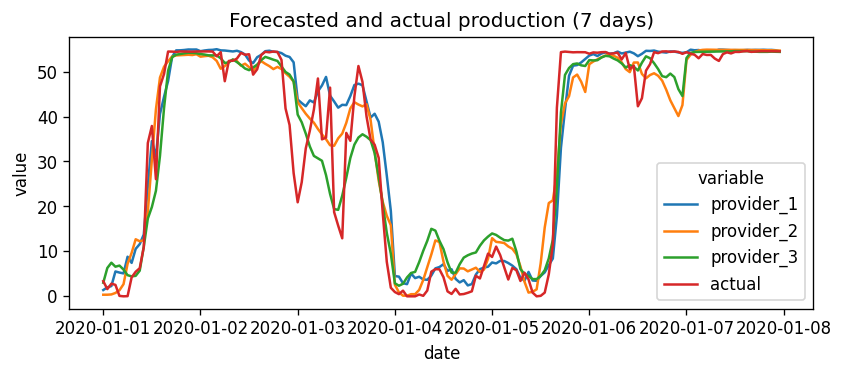

In [57]:
# visualize forecasted and actual productions
data = pd.DataFrame({
    "date": actual_generation.date[:168],
    "provider_1": provider_1[:168]["power"],
    "provider_2": provider_2[:168]["power"],
    "provider_3": provider_3[:168]["power"],
    "actual": actual_generation["power"],
})

plt.figure(figsize=(8, 3))

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(data, ["date"])).set(title="Forecasted and actual production (7 days)")

We also plot the averaged out values for the three providers along with the ground truth data and the third provider.

[Text(0.5, 1.0, 'Average forecasted and actual production (7 days)')]

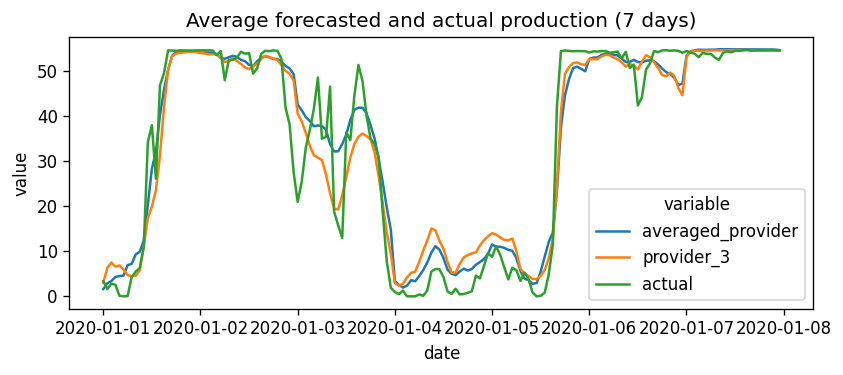

In [58]:
# visualize forecasted and actual productions
data = pd.DataFrame({
    "date": actual_generation.date[:168],
    "averaged_provider": average_provider[:168]["power"],
    "provider_3": provider_3[:168]["power"],
    "actual": actual_generation["power"],
})
plt.figure(figsize=(8, 3))

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(data, ["date"])).set(title="Average forecasted and actual production (7 days)")

### Comparing the quality of the four forecasts

We see that the averaged provider data better fits the actual data. To quantity it we compute the mse of the forecasts of each provider on the first week of data :

In [59]:
print('MSE of {forecast} is {rmse}'.format(forecast = 'forecast_provider_1', rmse = ((provider_1[:168].power - actual_generation[:168].power) ** 2).mean() ** 0.5))
print('MSE of {forecast} is {rmse}'.format(forecast = 'forecast_provider_2', rmse = ((provider_2[:168].power - actual_generation[:168].power) ** 2).mean() ** 0.5))
print('MSE of {forecast} is {rmse}'.format(forecast = 'forecast_provider_3', rmse = ((provider_3[:168].power - actual_generation[:168].power) ** 2).mean() ** 0.5))
print('MSE of {forecast} is {rmse}'.format(forecast = 'forecast_average_provider', rmse = ((average_provider[:168].power - actual_generation[:168].power) ** 2).mean() ** 0.5))

MSE of forecast_provider_1 is 6.935762520415258
MSE of forecast_provider_2 is 6.5225388737236
MSE of forecast_provider_3 is 6.3139926987165484
MSE of forecast_average_provider is 5.807227581587172


We notice that indeed the average production is the one which manages to most accurately predict the actual data

### Train/Validation/Test splits

We will now split our data into training, validation, and test sets

In [60]:
X = average_provider.drop(['power','date'], axis = 1)[:-24]
y = actual_generation['power']

X_test = average_provider.drop(['power','date'], axis = 1)[-24:]
y_test = average_provider['power'][-24:]

print(len(X))
print(len(y))
print(len(y_test))

from sklearn.model_selection import train_test_split 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.1, random_state = 42, shuffle = False
)

12504
12504
24


## Linear Regression
Linear Regression is an interpratable approach in forecasting problems as we have. Is is convenient to find relationships between continious variables.

This method aims to find the line that best fits the target variable acording to the other variables.

The forumula is :

$$y = \alpha + \beta x$$


We plot a correlation heatmap for our data to find any linear realtion between the variables.

Correlation values take range between -1 and 1. -1 being anticorrrelated, 1 is highly correlated and 0 indicates that there is no obvious relation.

[Text(0.5, 1.0, 'Feature correlation')]

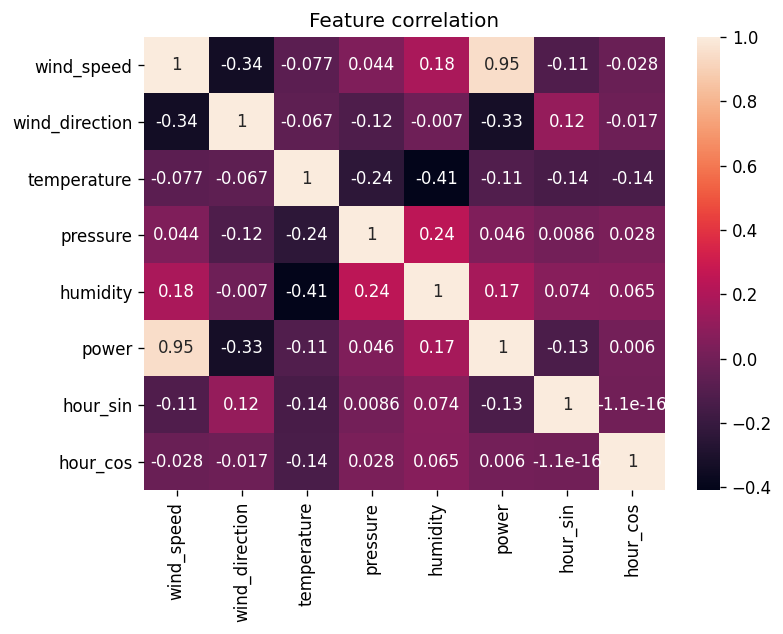

In [66]:
plt.figure(figsize=(7, 5))
sns.heatmap(average_provider.corr(), annot=True).set(title="Feature correlation")

wind_speed is the only feature that is strongly correlated with the production so we can try to fit a very basic linear regression:

[Text(0.5, 1.0, 'Power production')]

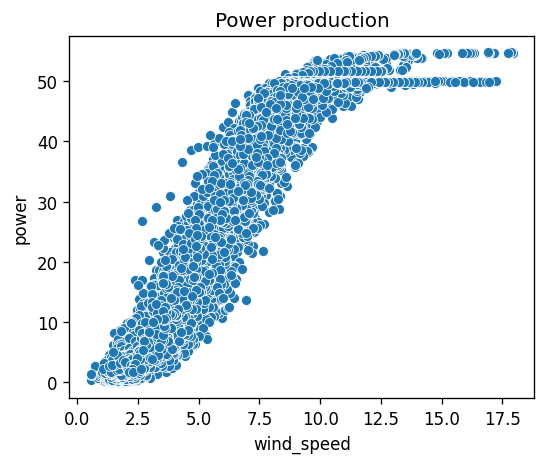

In [69]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x="wind_speed", y="power", data=average_provider).set(title="Power production")

In [70]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X=np.array(X_train["wind_speed"]).reshape(-1, 1), y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
train_mae = np.mean(np.abs(reg.predict(np.array(X_train["wind_speed"]).reshape(-1, 1)) - y_train))
valid_mae = np.mean(np.abs(reg.predict(np.array(X_val['wind_speed']).reshape(-1, 1)) - y_val))
test_mae = np.mean(np.abs(reg.predict(np.array(X_test['wind_speed']).reshape(-1, 1)) - y_test))

print(f"Test MAE: {test_mae} | valid R²: {reg.score(X=np.array(X_test['wind_speed']).reshape(-1,1), y=y_test)}")
print(f"Valid MAE: {valid_mae} | valid R²: {reg.score(X=np.array(X_val['wind_speed']).reshape(-1,1), y=y_val)}")
print(f"Train MAE: {train_mae} | train R²: {reg.score(np.array(X_train['wind_speed']).reshape(-1, 1), y_train)}")

Test MAE: 1.624165378134281 | valid R²: 0.5322968616723067
Valid MAE: 7.742309843943446 | valid R²: 0.5737251906829863
Train MAE: 7.848399057026317 | train R²: 0.7340595317095971


Our linear regression return acceptable results. The MAE score on valid test is 7.74 which is at the same order of magnitude of the provider predictions.

## ARIMA

ARIMA is a time series forecasting approach. It means that predictions are made only by considering the time variable not the other covariates. 

The idea is to analyse the series trend and combine past observations of the target variable to come with a new prediction.

In [72]:
%%capture
!pip install statsmodels
import statsmodels.api as sm

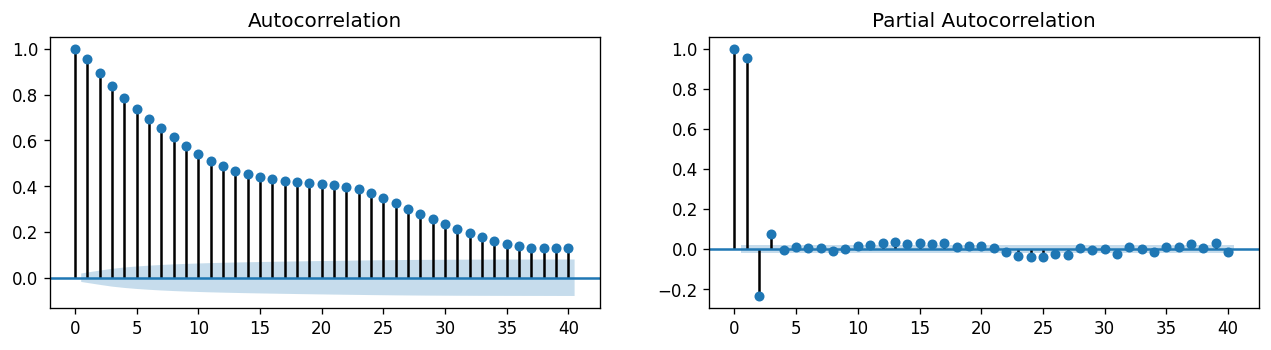

In [74]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(13,3))
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(y_train, lags=40, ax=ax1)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=ax2)

In [75]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_train.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.441802
p-value: 0.000000


The p-value is less than 0.05 so we don't need to differentiate (our signal is already stationnary).

In [76]:
arima = sm.tsa.ARIMA(y_train, order=(3, 0, 0))
res = arima.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  power   No. Observations:                11253
Model:                     ARMA(3, 0)   Log Likelihood              -35459.858
Method:                       css-mle   S.D. of innovations              5.652
Date:                Sun, 06 Jun 2021   AIC                          70929.716
Time:                        08:01:06   BIC                          70966.358
Sample:                             0   HQIC                         70942.046
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.9290      1.064     21.551      0.000      20.844      25.014
ar.L1.power     1.1981      0.009    127.465      0.000       1.180       1.216
ar.L2.power    -0.3236      0.014    -22.513      0.000      -0.352      -0.295
ar.L3.power     0.0755      0.009      8.034      0.000       0.057       0.094
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0648           -0.0000j            1.0648           -0.0000
AR.2            1.6102           -3.1374j            3.5265           -0.1745
AR.3            1.6102           +3.1374j            3.5265            0.1745
-----------------------------------------------------------------------------
"""

We obtained the best model (according to the AIC) with an ARIMA(3, 0, 0).

The p-values of the AR3 are all highly significant (<< 0.05).

In [77]:
preds_train = arima.predict(res.params, start=0, end=11252)
preds_val = arima.predict(res.params, start=11253, end=12503)
preds_test = arima.predict(res.params, start=12504, end=12527)

In [78]:
train_mae = np.mean(np.abs(preds_train - y_train.values))
val_mae = np.mean(np.abs(preds_val - y_val.values))
test_mae = np.mean(np.abs(preds_test[-24:] - y_test.values))

print(f"Train MAE: {train_mae} \nValidation MAE: {val_mae} \nTest MAE: {test_mae}")

Train MAE: 3.6226055904122463 
Validation MAE: 17.567475384532436 
Test MAE: 16.527938297460064


The ARIMA model can fit the training data accurately (MAE: 3.6, way better than the linear regression), but performs very poorly on the validation and test sets. Indeed, it the predictions are too smooth to get accurate predictions on an hourly basis:

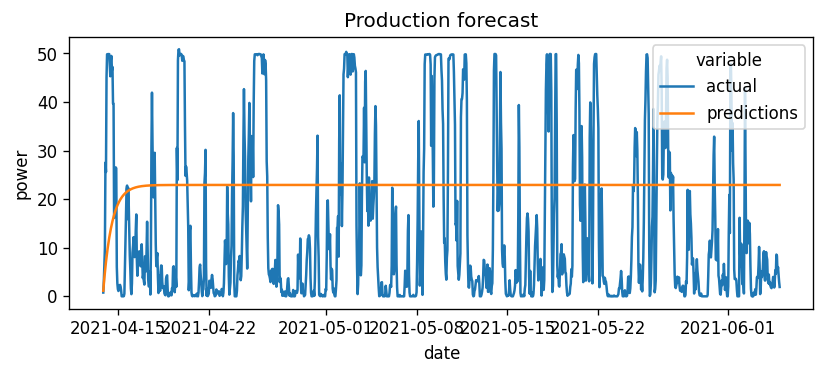

In [82]:
forecast_data = pd.DataFrame({
    "date": provider_1.loc[y_val.index.tolist()].date,
    "actual": y_val,
    "predictions": preds_val,
})
plt.figure(figsize=(8, 3))
sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(forecast_data, ["date"])).set(ylabel="power", title="Production forecast")

sns.lineplot()

## LSTM


As we're dealing with time series data in this challenge, we choose to use a recurrent neural network with LSTM cells. Indeed, those networks are very powerful in the context of generalization on data with temporal dependencies, and at the end have indeed allowed us to make predictions in the same range of that of the three providers.

We begin by applying a min max scaler to the data, in order to make sure our gradient descent works as well possible by having all our data in the same range. 

In [83]:
### scaling data

from sklearn.preprocessing import MinMaxScaler

x = X_train.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train_scaled = pd.DataFrame(x_scaled)
X_val_scaled = pd.DataFrame(min_max_scaler.transform(X_val.values))
X_test_scaled = pd.DataFrame(min_max_scaler.transform(X_test.values))

We then implement some data reshaping to make it work with a neural net, then build a small sequential network with LSTM cells to train. We use the Adam optimizer with default parameters. 

In [84]:
import tensorflow
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [85]:
X_tr = X_train_scaled.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_va = X_val_scaled.to_numpy().reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_tes = X_test_scaled.to_numpy().reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [95]:
# construct network
model = Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape = (X_tr.shape[1],X_tr.shape[2])))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128))
model.add(layers.Dense(1))

#compile network
model.compile(loss='mae', optimizer = 'adam')

# summary
# model.summary()

# fit network
model_lstm = model.fit(X_tr, 
                      y_train, 
                      epochs=10, batch_size=64, verbose=0,
                      shuffle=False, validation_data = (X_va, y_val))

Our model reaches a very satisfying error of 6.72 on the validation set, after a 10 epoch training. 

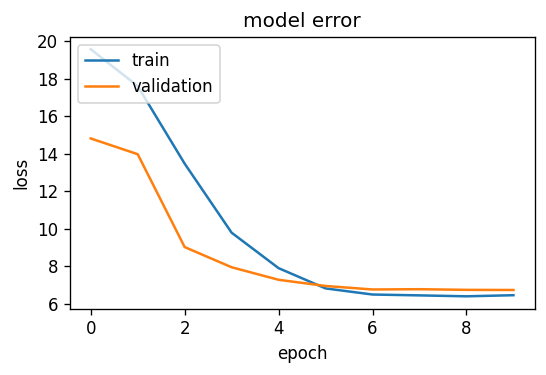

In [96]:
#  "Loss"
plt.figure(figsize=(5, 3))
plt.plot(model_lstm.history['loss'])
plt.plot(model_lstm.history['val_loss'])
plt.title('model error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Forecasting today's production with the LSTM

Finally we predict yesterday's production using our LSTM network

In [90]:
final_preds = model.predict(X_tes)

[Text(0, 0.5, 'power'), Text(0.5, 1.0, 'Production forecast for 2021-06-05')]

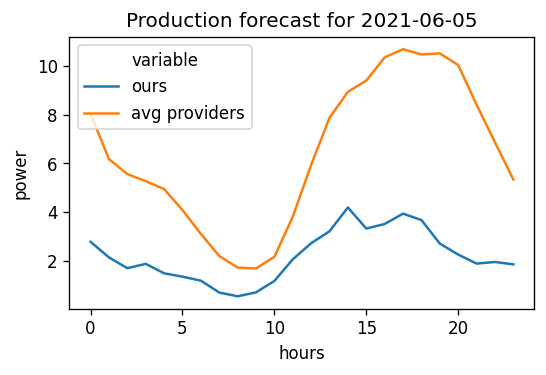

In [97]:
predictions = pd.DataFrame({
    "hours": range(24),
    "ours": final_preds.reshape(-1),
    "avg providers": y_test,
})

plt.figure(figsize=(5,3))

sns.lineplot(x="hours", y="value", hue="variable",
             data=pd.melt(predictions, ["hours"])).set(title="Production forecast for 2021-06-05", ylabel="power")

In [ ]:
# exporting our forecasts
submission = pd.DataFrame(data={"Datekey": [20210605]*24,
                   "Hour": [f"{hour:02}:00" for hour in range(24)],
                   "PowerWOAvailability": final_preds.reshape(-1) })

In [ ]:
submission.to_csv("./submission.csv", sep=";", index=False)